## Imports and data preprocessing

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import PowerTransformer, RobustScaler
from transformer_pipeline import get_features_transformer,drop_rows
from IPython.display import display, HTML
from scipy.spatial import distance
import warnings
warnings.filterwarnings("ignore")

In [45]:
df = pd.read_csv("data/movie_statistic_dataset.csv")
df = drop_rows(df)

## K-Means Model

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [47]:
KM_df1 = df.copy()
KM_df2 = df.copy()
KM_transformer = get_features_transformer(MinMaxScaler(),
                                          MinMaxScaler(),
                                          MinMaxScaler(),
                                          MinMaxScaler())
KM_X = KM_transformer.fit_transform(KM_df)
KM_X.shape

(3490, 20)

<h2 align='center'>Elbow Method</h2>

In [48]:
def count_wcss_scores(X, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 
        scores.append(wcss)
    return scores

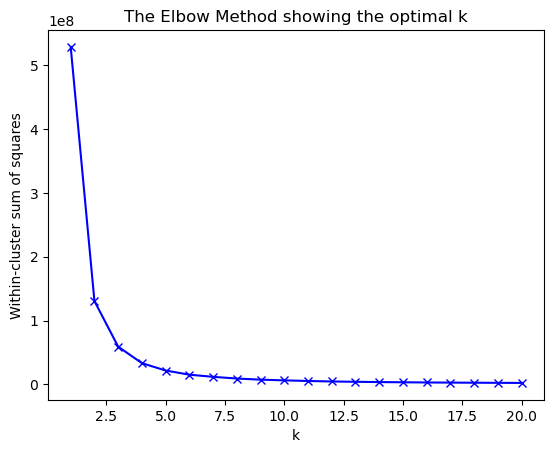

In [49]:
wcss_vec = count_wcss_scores(KM_X, 20)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [50]:
kmeans = KMeans(n_clusters=4, random_state=14)
kmeans.fit(KM_X)
y_kmeans = kmeans.predict(KM_X)
KM_df1['cluster'] = y_kmeans
# display(HTML(KM_df.to_html()))

In [51]:
print(KM_df1['cluster'].value_counts())

2    1355
0     976
3     654
1     505
Name: cluster, dtype: int64


In [52]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)


print(f'Minimal distance between clusters = {count_clustering_scores(KM_X, 4, KMeans, min_interclust_dist):.2f}.')
print(f'Average distance between points in the same class = '
      f'{count_clustering_scores(KM_X, 4, KMeans, mean_inclust_dist):.2f}.')
print(f'Standard deviation of distance between points in the same class = '
      f'{count_clustering_scores(KM_X, 4, KMeans, std_dev_of_inclust_dist):.3f}.')
print(f'Average distance to cluster center = '
      f'{count_clustering_scores(KM_X, 4, KMeans, mean_dist_to_center):.2f}.')

Minimal distance between clusters = 5.01.
Average distance between points in the same class = 120.56.
Standard deviation of distance between points in the same class = 16.955.
Average distance to cluster center = 89.50.


<h2 align='center'>Silhouette Score</h2>

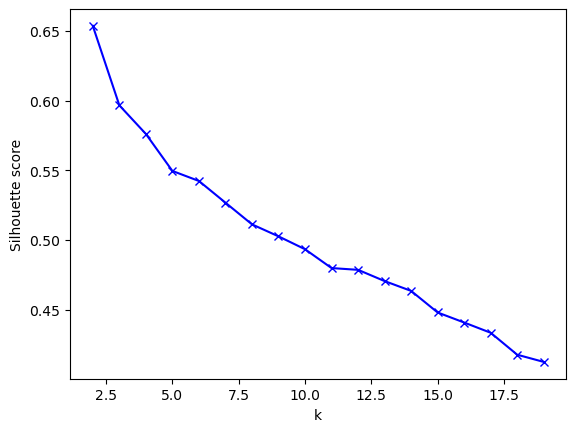

In [53]:
cluster_num_seq = range(2, 20)
silhouette_vec = count_clustering_scores(KM_X, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

In [74]:
kmeans = KMeans(n_clusters=6, random_state=14)
kmeans.fit(KM_X)
y_kmeans = kmeans.predict(KM_X)
KM_df2['cluster'] = y_kmeans
# display(HTML(KM_df.to_html()))

In [84]:
print(KM_df2['cluster'].value_counts())

5    894
1    722
4    607
0    464
2    414
3    389
Name: cluster, dtype: int64


In [76]:
from scipy.spatial import distance
import numpy as np


def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)


print(f'Minimal distance between clusters = {count_clustering_scores(KM_X, 6, KMeans, min_interclust_dist):.2f}.')
print(f'Average distance between points in the same class = '
      f'{count_clustering_scores(KM_X, 6, KMeans, mean_inclust_dist):.2f}.')
print(f'Standard deviation of distance between points in the same class = '
      f'{count_clustering_scores(KM_X, 6, KMeans, std_dev_of_inclust_dist):.3f}.')
print(f'Average distance to cluster center = '
      f'{count_clustering_scores(KM_X, 6, KMeans, mean_dist_to_center):.2f}.')

Minimal distance between clusters = 4.58.
Average distance between points in the same class = 82.91.
Standard deviation of distance between points in the same class = 16.470.
Average distance to cluster center = 61.19.


Does something changed after increasing number of clusters?
* ~10% loss in minimal distance between clusters
* ~30% loss in distance between points in clusters
* slightly smaller deviation
* ~30% smaller distance to cluster center

Better metric values, but does clusters make sense?

<h3>For String columns</h3>

In [78]:
def assign_color(cluster):
    if cluster == 0:
        return 'red'
    elif cluster == 1:
        return 'blue'
    elif cluster == 2:
        return 'green'
    elif cluster == 3:
        return 'yellow'
    elif cluster == 4:
        return 'orange'
    elif cluster == 5:
        return 'purple'

tmp1 = KM_df1.copy()
tmp1['colour'] = tmp1['cluster'].apply(assign_color)

tmp2 = KM_df2.copy()
tmp2['colour'] = tmp2['cluster'].apply(assign_color)

html1 = tmp1.style.apply(lambda row: ['background-color: ' + row['colour']] * len(row), axis=1).render()
with open('elbow_clusters.html', 'w') as f:
    f.write(html1)

html2 = tmp2.style.apply(lambda row: ['background-color: ' + row['colour']] * len(row), axis=1).render()
with open('silhouette_clusters.html', 'w') as f:
    f.write(html2)

<h3>For Numeric columns</h3>

In [88]:
print('--------- Cluster 0 ---------')
KM_df1[KM_df1['cluster'] == 0].describe().T


--------- Cluster 0 ---------


,count,mean,std,min,25%,50%,75%,max
runtime_minutes,976.0,1.110912e+02,1.952873e+01,75.000000,9.800000e+01,1.080000e+02,1.210000e+02,2.710000e+02
movie_averageRating,976.0,6.428279e+00,9.269965e-01,3.400000,5.800000e+00,6.500000e+00,7.100000e+00,9.200000e+00
movie_numerOfVotes,976.0,1.156561e+05,1.514583e+05,141.000000,2.988800e+04,6.756800e+04,1.351628e+05,1.870922e+06
approval_Index,976.0,5.133238e+00,1.156613e+00,2.052804,4.383244e+00,5.068466e+00,5.891256e+00,9.643790e+00
Production budget $,976.0,3.084500e+07,1.751758e+07,87000.000000,1.600000e+07,3.000000e+07,4.200000e+07,7.000000e+07
Domestic gross $,976.0,3.958614e+07,4.012396e+07,3080.000000,1.357860e+07,2.940864e+07,5.176110e+07,3.501264e+08
Worldwide gross $,976.0,7.283275e+07,8.345742e+07,12836.000000,2.046128e+07,4.678433e+07,9.409196e+07,7.061028e+08
cluster,976.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [90]:
print('--------- Cluster 1 ---------')
KM_df1[KM_df1['cluster'] == 1].describe().T

--------- Cluster 1 ---------


,count,mean,std,min,25%,50%,75%,max
runtime_minutes,505.0,1.062574e+02,2.114005e+01,66.000000,9.300000e+01,1.020000e+02,1.130000e+02,2.100000e+02
movie_averageRating,505.0,6.433069e+00,1.030832e+00,2.400000,5.900000e+00,6.600000e+00,7.100000e+00,8.500000e+00
movie_numerOfVotes,505.0,4.381989e+04,8.250744e+04,23.000000,5.845000e+03,1.686800e+04,4.677800e+04,1.129033e+06
approval_Index,505.0,4.495418e+00,1.276467e+00,0.860157,3.667281e+00,4.428577e+00,5.374731e+00,8.584128e+00
Production budget $,505.0,4.573206e+06,3.374636e+06,50000.000000,1.500000e+06,4.000000e+06,7.000000e+06,1.100000e+07
Domestic gross $,505.0,1.178461e+07,2.021282e+07,264.000000,8.726430e+05,4.151836e+06,1.323527e+07,1.748035e+08
Worldwide gross $,505.0,1.810128e+07,3.358067e+07,884.000000,1.744952e+06,7.298786e+06,1.882804e+07,3.282035e+08
cluster,505.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [91]:
print('--------- Cluster 2 ---------')
KM_df1[KM_df1['cluster'] == 2].describe().T

--------- Cluster 2 ---------


,count,mean,std,min,25%,50%,75%,max
runtime_minutes,1355.0,1.170000e+02,2.010736e+01,65.000000,1.030000e+02,1.150000e+02,1.280000e+02,2.420000e+02
movie_averageRating,1355.0,6.626790e+00,9.363722e-01,1.600000,6.100000e+00,6.600000e+00,7.300000e+00,9.300000e+00
movie_numerOfVotes,1355.0,2.470198e+05,2.982544e+05,13.000000,7.238250e+04,1.527240e+05,3.015520e+05,2.695887e+06
approval_Index,1355.0,5.689039e+00,1.238213e+00,0.449597,4.875200e+00,5.636748e+00,6.445173e+00,1.000000e+01
Production budget $,1355.0,7.165587e+07,5.849883e+07,68000.000000,2.800000e+07,5.750000e+07,9.750000e+07,4.600000e+08
Domestic gross $,1355.0,9.382994e+07,9.798964e+07,3200.000000,3.299419e+07,6.518760e+07,1.254271e+08,8.141151e+08
Worldwide gross $,1355.0,2.219217e+08,2.690789e+08,47329.000000,5.692941e+07,1.374897e+08,2.886024e+08,2.923706e+09
cluster,1355.0,2.000000e+00,0.000000e+00,2.000000,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00


In [92]:
print('--------- Cluster 3 ---------')
KM_df1[KM_df1['cluster'] == 3].describe().T

--------- Cluster 3 ---------


,count,mean,std,min,25%,50%,75%,max
runtime_minutes,654.0,1.080275e+02,1.931703e+01,68.000000,9.500000e+01,1.050000e+02,1.167500e+02,2.290000e+02
movie_averageRating,654.0,6.304128e+00,1.096786e+00,1.500000,5.700000e+00,6.400000e+00,7.100000e+00,8.400000e+00
movie_numerOfVotes,654.0,7.157222e+04,9.487357e+04,21.000000,1.710250e+04,3.946200e+04,8.614750e+04,8.082300e+05
approval_Index,654.0,4.780720e+00,1.256831e+00,1.010202,3.929612e+00,4.793775e+00,5.563800e+00,8.075424e+00
Production budget $,654.0,1.542032e+07,7.421201e+06,100000.000000,1.000000e+07,1.500000e+07,2.000000e+07,3.000000e+07
Domestic gross $,654.0,2.360650e+07,2.676282e+07,918.000000,5.117330e+06,1.540468e+07,3.245383e+07,1.880244e+08
Worldwide gross $,654.0,3.847428e+07,4.987302e+07,14443.000000,8.463849e+06,2.307588e+07,4.768663e+07,3.874723e+08
cluster,654.0,3.000000e+00,0.000000e+00,3.000000,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00


## K-Medoids Model

In [ ]:
from sklearn_extra.cluster import KMedoids

## AgglomerativeClustering

add dendrogram here